In [75]:
import numpy as np
from numpy import cos, sin
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


## calibration

In [76]:
Xdn = pd.read_csv(r'data\calibration\side\X1.csv')
Xup = pd.read_csv(r'data\calibration\side\X2.csv')

Ydn = pd.read_csv(r'data\calibration\stand\Y1.csv')
Yup = pd.read_csv(r'data\calibration\stand\Y2.csv')

Zdn = pd.read_csv(r'data\calibration\lay\Z1.csv')
Zup = pd.read_csv(r'data\calibration\lay\Z2.csv')

In [77]:
bXa = (Xdn.iloc[:,0].mean()+Xup.iloc[:,0].mean())/2
bYa = (Ydn.iloc[:,1].mean()+Yup.iloc[:,1].mean())/2
bZa = (Zdn.iloc[:,2].mean()+Zup.iloc[:,2].mean())/2

bXg = (Xdn.iloc[:,3].mean()+Xup.iloc[:,3].mean())/2
bYg = (Ydn.iloc[:,4].mean()+Yup.iloc[:,4].mean())/2
bZg = (Zdn.iloc[:,5].mean()+Zup.iloc[:,5].mean())/2

ba = np.array([bXa,bYa,bZa])
bg = np.array([bXg,bYg,bZg])

In [78]:
# read data
# acc_1 = pd.read_csv(r'data\70_steps_acc.csv')
# gyro_1 = pd.read_csv(r'data\70_steps_gyro.csv')
# gravity = pd.read_csv(r'data\24_steps\Gravity.csv')

In [79]:
ins = pd.read_csv(r'data\calibration\side\X1.csv')
ins.columns = ['ax','ay','az','gx','gy','gz','time','date']
ins.head()

,ax,ay,az,gx,gy,gz,time,date
0,9.1614,-0.6476,-0.3292,0.0,0.0000,0.0011,3,2021-01-13 22:37:30:585
1,9.1566,-0.6512,-0.3172,0.0,0.0000,0.0011,24,2021-01-13 22:37:30:606
2,9.1566,-0.6512,-0.3172,0.0,0.0000,0.0011,43,2021-01-13 22:37:30:625
3,9.1566,-0.6512,-0.3172,0.0,0.0000,0.0011,64,2021-01-13 22:37:30:646
4,9.1566,-0.6512,-0.3172,0.0,-0.0011,-0.0011,83,2021-01-13 22:37:30:665


In [80]:
# order column
# acc_1 = acc_1[['time','x','y','z']]
# gyro_1 = gyro_1[['time','x','y','z']]
# gravity = gravity[['time','x','y','z']]

acc_1 = ins[['time','ax','ay','az']]
gyro_1 = ins[['time','gx','gy','gz']]

gyro_1.head()

,time,gx,gy,gz
0,3,0.0,0.0000,0.0011
1,24,0.0,0.0000,0.0011
2,43,0.0,0.0000,0.0011
3,64,0.0,0.0000,0.0011
4,83,0.0,-0.0011,-0.0011


In [81]:
# add gravity to acceleration
# acc_1.iloc[:,1:4] = acc_1.iloc[:,1:4] + gravity.iloc[:,1:4]
#
# acc_1.head()

In [82]:
# acc_1= acc_1.iloc[5:,:]
# gyro_1= gyro_1.iloc[5:,:]
#
# acc_1 = acc_1.reset_index()
# gyro_1 = gyro_1.reset_index()
#
# acc_1.head()

In [83]:
# Total acceleration
acc_1['acceleration'] =np.sqrt(acc_1['ax']**2+acc_1['ay']**2+acc_1['az']**2)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
# # join dataframes
# df1 = acc_1.join(gyro_1.set_index('time'),on="time",lsuffix='_acc', rsuffix='_gyro')


In [85]:
# Define the first sample as '0' and convert from nanoseconds to seconds
# acc_1['time'] = (acc_1['time']-acc_1.loc[0,'time'])*(1e-9)
# gyro_1['time'] = (gyro_1['time']-gyro_1.loc[0,'time'])*(1e-9)

acc_1['time'] = (acc_1['time']-acc_1.loc[0,'time'])*(1e-3)
gyro_1['time'] = (gyro_1['time']-gyro_1.loc[0,'time'])*(1e-3)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [86]:
# bais
acc_1.iloc[:,1:4] = acc_1.iloc[:,1:4]-ba
gyro_1.iloc[:,1:4] = gyro_1.iloc[:,1:4]-bg

acc_1.head()

C:\Users\DELL\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can a

,time,ax,ay,az,acceleration
0,0.000,9.800202,-0.019022,-0.279051,9.190158
1,0.021,9.795402,-0.022622,-0.267051,9.185206
2,0.040,9.795402,-0.022622,-0.267051,9.185206
3,0.061,9.795402,-0.022622,-0.267051,9.185206
4,0.080,9.795402,-0.022622,-0.267051,9.185206


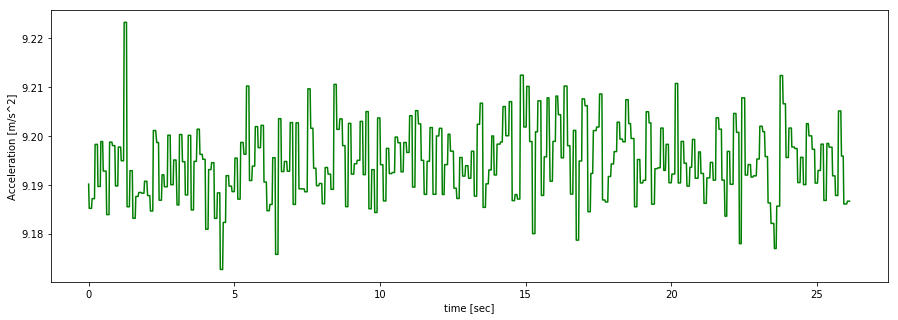

In [87]:
# plot acceleration
fig = plt.figure(figsize=(15,5))
plt.plot(acc_1['time'],acc_1['acceleration'], '-g')
plt.xlabel('time [sec]')
plt.ylabel('Acceleration [m/s^2]')
plt.show()

In [88]:
# # plot gyroscope data in each axes
# fig, axs = plt.subplots(nrows=3, ncols=1,sharex=True, figsize=(15,5))
#
# axs[0].plot(gyro_1['time'],gyro_1['x'], '-r')
# axs[0].set_ylabel('omega x')
#
# axs[1].plot(gyro_1['time'],gyro_1['y'], '-g')
# axs[1].set_ylabel('omega y')
#
# axs[2].plot(gyro_1['time'],gyro_1['z'], '-b')
# axs[2].set_ylabel('omega z')
#
# axs[2].set_xlabel('time [sec]')
#
#
# plt.show()

In [89]:
def vector2anti_Sim(v):
    return np.array([[0,-v[2],v[1]],[v[2],0,-v[0]],[-v[1],v[0],0]])

In [90]:
# Initial parameters
Re = 6378137
e = 0.0818191908
omega_ie = (2*np.pi)/(24*60*60) # Earth turn rate

# Calc' initial angles (10 sec' in stationary conditions
# fx = acc_1['x'].mean()
# fy = acc_1['y'].mean()
# fz = acc_1['z'].mean()

fx = acc_1.loc[0,'ax']
fy = acc_1.loc[0,'ay']
fz = acc_1.loc[0,'az']

roll_0 = np.arctan2(-fy, -fz)
pitch_0 = np.arctan2(-fx, np.sqrt(fz**2 + fy**2))
# from compass
yaw_0 = np.deg2rad(230)

# from google map
lat_0 = np.deg2rad(32.780724)
lon_0 = np.deg2rad(35.020606)
h_0 = 183

v_0 = np.array([[0,0,0]]).T
# r_0 = np.array([[lat_0, lon_0, h_0]]).T
r_0 = np.array([[0, 0, 0]]).T

Rm = Re * (1 - e ** 2) / (1 - e ** 2 * sin(lat_0) * 2) ** (3 / 2)
Rn = Re / (1 - e ** 2 * sin(lat_0) * 2) ** (1 / 2)
g = 9.7803 + 0.051799*sin(lat_0) - h_0*0.94114/1000000
gn = np.array([[0,0,g]]).T

In [91]:
# Rotation matrix
T_roll = np.array([[cos(roll_0),0,-sin(roll_0)],[0,1,0],[sin(roll_0),0,cos(roll_0)]])
T_pitch = np.array([[1,0,0],[0,cos(pitch_0),sin(pitch_0)],[0,-sin(pitch_0),cos(pitch_0)]])
T_yaw = np.array([[cos(yaw_0),sin(yaw_0),0],[-sin(yaw_0),cos(yaw_0),0],[0,0,1]])

tb_n_0 = T_roll.dot(T_pitch.dot(T_yaw))

In [92]:
# find the time interval between every sample
n = acc_1.shape[0]
samples = acc_1.to_numpy()
dt = samples[1:n, 0] - samples[0:(n - 1), 0]
# dt = np.average(dt)

In [93]:
# init the lists of the navigation solution
Pose = [r_0]
Velocity = [v_0]
Attitude = [tb_n_0]

In [94]:
for i in range(n-1):

    # calculate next Tb_n
    sigma_x = dt[i] * vector2anti_Sim(gyro_1.iloc[i,1:4])
    sigma = np.sqrt(sigma_x[0,1]**2 + sigma_x[0,2]**2 + sigma_x[1,2]**2)
    tb_n = tb_n_0.dot(np.identity(3) + (sin(sigma)/sigma)*sigma_x + ((1-cos(sigma))/sigma**2)*np.dot(sigma_x, sigma_x))

    Attitude.append(tb_n)

    # calculate next V dot

    # phi = r_0[0,0]
    # h = r_0[2,0]
    phi = lat_0
    h = h_0
    # full calculation
    # omega_ie_n =  vector2anti_Sim(np.array([omega_ie*cos(phi),0,-omega_ie*sin(phi)]))
    # omega_en = vector2anti_Sim(np.array([-v_0[1,0]/(Rn+h),-v_0[0,0]/(Rm+h),-v_0[1,0]*np.tan(phi)/(Rn+h)]))
    # f_b =g*row[1:4][:, np.newaxis]
    # v_dot = np.dot(tb_n, f_b) + gn - np.dot(omega_en+2*omega_ie_n, v_0)

    f_b = acc_1.iloc[i,1:4][:, np.newaxis]
    # simplify
    v_dot = np.dot(tb_n, f_b) + gn

    # calculate next V
    v = v_0 + dt[i]*v_dot
    Velocity.append(v)

    # calculate next position
    # D = np.dot(np.identity(3),np.array([1/(Rm+h),1/(cos(phi)*(Rn+h)),-1]))
    # D = np.diag(np.array([1/(Rm+h),1/(cos(phi)*(Rn+h)),-1]))
    # r_dot = np.dot(D, v)

    # simplify
    r_dot = v

    # calculate next R
    r = r_0 + dt[i]*r_dot
    Pose.append(r)

    tb_n_0 = tb_n
    v_0 = v
    r_0 = r

In [95]:
Velocity = np.reshape(np.array(Velocity),(len(Velocity),3))
Pose = np.reshape(np.array(Pose),(len(Pose),3))
Attitude = np.array(Attitude)

In [96]:
# transform R from rad to degrees (lat,lon,h)
# Pose[:,0:2] = np.rad2deg(Pose[:,0:2])

V_norm = np.sqrt(Velocity[:, 0]**2 + Velocity[:,1]**2 + Velocity[:,2]**2)

print('start point :',Pose[0])
print('end point:', Pose[-1])
# deg_to_meter = 108000
deltaX = np.sqrt((Pose[-1, 0]-Pose[0, 0])**2 + (Pose[-1, 1]-Pose[0, 1])**2) # * deg_to_meter
deltaH = Pose[-1,2] - Pose[0,2]
print('total dist [m]:', deltaX)
print('altitude change [m]:', deltaH)
print('average speed [m/sec]:', np.average(V_norm))

start point : [0. 0. 0.]
end point: [-2308.89253715   132.36173995  5769.94223352]
total dist [m]: 2312.683371826201
altitude change [m]: 5769.942233518314
average speed [m/sec]: 237.82431857437078


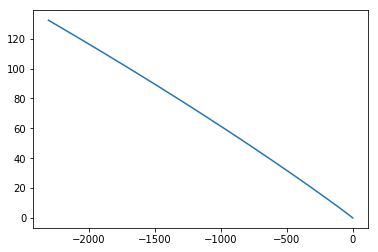

In [97]:
plt.figure()
plt.plot(Pose[:,0],Pose[:,1])